In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [2]:
from sys import stdout
from time import time

In [3]:
X = pd.read_csv("data/X.csv")
data = X.groupby('user')

In [11]:
def remove_zeros_rows(x):
    nz = np.nonzero(x.any(axis=1))[0]
    return (x[nz, :])

def build_calendar(X):
    s = csr_matrix((X['sum'].values, (X.user.values - 1, X.day.values - 1))).todense()
    s = np.concatenate([s, np.zeros((s.shape[0], 3), dtype=np.int)], axis=1)
    return ([0] + [remove_zeros_rows(np.asarray(user.reshape(448//7, 7))) for user in s])

In [12]:
%time cal = build_calendar(X)

CPU times: user 3.48 s, sys: 157 ms, total: 3.63 s
Wall time: 3.66 s


In [13]:
%time data_pred = data.last().values
data_pred = data_pred[:, 0]

CPU times: user 113 ms, sys: 20 ms, total: 133 ms
Wall time: 180 ms


In [14]:
%time test = data.apply(lambda df: df.values[-2])
test = np.array(list(test))
data_test, target_test = test[:, 0], test[:, 1]

CPU times: user 913 ms, sys: 46.7 ms, total: 960 ms
Wall time: 982 ms


In [16]:
class msusums(object):
        
    def fit(self, cal):
        self.calendar = cal
            
    def predict(self, u, day, delta, gamma, alpha=0.5, beta=0.33):
        user_cal = self.calendar[u]
        day = (day - 1) % 7
        
        buy_week = user_cal[:, day]
        buy_week = buy_week[buy_week.nonzero()][:-1]
        
        buy_all = user_cal[user_cal.nonzero()][:-1]
        
        w1 = (1 - (np.arange(buy_week.size, 0, -1) - 1) / buy_week.size) ** delta
        w1 /= w1.sum()
        w2 = 1 / np.arange(buy_week.size, 0, -1) ** gamma
        w2 /= w2.sum()
        
        return alpha * np.sum(w1 * buy_week) +\
               beta * np.sum(w2 * buy_week) +\
               (1 - alpha - beta) * np.mean(buy_all)
    
    def predict_arr(self, data_pred, delta=0.375, gamma=3.33, alpha=0.5, beta=0.33):
        pred = []
        for u in range(len(data_pred)):
            pred += [self.predict(u + 1, data_pred[u], delta, gamma, alpha, beta)]
            
        return pred
    
    def predict_test(self, data_pred, target_pred, delta=0.375, gamma=3.33, alpha=0.42, beta=0.33, debug=False):
        start = time()
        pred = self.predict_arr(data_pred, delta, gamma, alpha, beta)
            
        if debug:
            print("{:.2f}sec elapsed for the test".format(time() - start))
        return mean_absolute_error(target_pred, pred)

In [17]:
reg = msusums()

In [18]:
reg.fit(cal)

In [38]:
%%time
num_i = 10
num_j = 10
p1 = np.linspace(0.0, 1, num_i)
p2 = np.linspace(0.0, 1, num_j)
res = np.zeros((num_i, num_j))
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        if (p1[i] + p2[j] > 1):
            res[i, j] = 1000
        else:
            res[i, j] = reg.predict_test(data_pred, ans_275['sum'].values, delta=0.44, gamma=0.72, alpha=p1[i], beta=p2[j])
        stdout.write('\r' + str((i * num_j + j + 1) / res.size * 100) + '%')
print('\n')

100.0%

CPU times: user 3min 59s, sys: 157 ms, total: 3min 59s
Wall time: 3min 59s


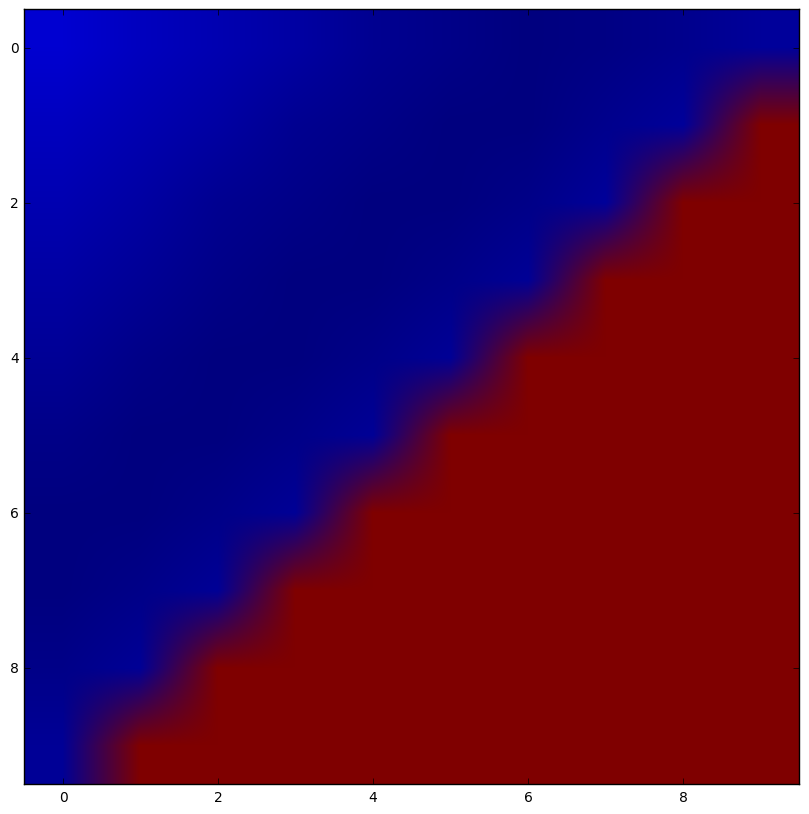

In [39]:
plt.figure(figsize=(10, 15))
plt.imshow(res);

In [40]:
m = np.argmin(res)

In [41]:
d, g = np.unravel_index(m, (num_i, num_j))

In [42]:
res[d, g]

26.585580606364562

In [43]:
p1[d], p2[g]

(0.22222222222222221, 0.44444444444444442)

In [45]:
reg.predict_test(data_test, target_test, delta=0.5, gamma=0.72, alpha=0.22, beta=0.44)

248.03187877040116

In [46]:
myres = reg.predict_arr(data_pred, delta=0.5, gamma=0.72, alpha=0.22, beta=0.44)

In [47]:
myres_csv = pd.DataFrame(data=myres, index=pd.RangeIndex(1, len(myres) + 1, name='user'), columns=['sum'])

In [48]:
myres_csv.to_csv("data/myans_1.csv")